In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

### 1. Read the training data

In [53]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["Rock", "R&B", "Acoustic"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


Rock
R&B
Acoustic


In [54]:
tracks_df['genre'].value_counts()

rock        2134
acoustic    1816
rnb         1508
Name: genre, dtype: int64

In [55]:
#check shape
playlist_df.shape, tracks_df.shape

((234, 7), (5458, 22))

In [56]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [57]:
#check null rows
# playlist_df[playlist_df.isnull().any(1)]
tracks_df[tracks_df.isnull().any(1)]


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name


In [58]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(5458, 22)

In [59]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

5417

In [60]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(5417, 22)

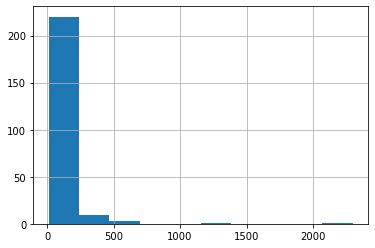

In [61]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

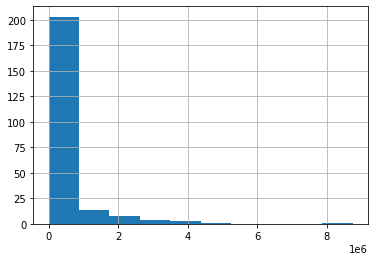

In [62]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [63]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

rock        0.393945
acoustic    0.327672
rnb         0.278383
Name: genre, dtype: float64

### 2. Refine the training data

In [64]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWXRqgorJj26U,Rock Classics,145,spotify,Spotify,8743130,rock
1,37i9dQZF1DXcF6B6QPhFDv,Rock This,50,spotify,Spotify,4490659,rock
2,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,150,spotify,Spotify,4111532,rock
3,37i9dQZF1DWYN0zdqzbEwl,Rock en Español,60,spotify,Spotify,3829864,rock
4,37i9dQZF1DX3oM43CtKnRV,00s Rock Anthems,50,spotify,Spotify,3474724,rock


In [65]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

acoustic    569
rock        452
rnb         300
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [66]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [67]:


tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    1321.000000
mean        0.669970
std         0.167473
min         0.000000
25%         0.558635
50%         0.687651
75%         0.797122
max         1.000000
Name: loudness, dtype: float64

In [68]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    1321.000000
mean        0.386345
std         0.193951
min         0.000000
25%         0.226175
50%         0.368054
75%         0.520612
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [69]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [70]:
tracks_df['genre'].value_counts()

acoustic    569
rock        452
rnb         300
Name: genre, dtype: int64

In [71]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,0hCB0YR03f6AmQaHbwWDe8,Whole Lotta Love - 1990 Remaster,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,70lQYZtypdCALtFVlQAcvx,333893,1969-10-22,75,0.412,0.902,...,0.04840,0.131000,0.4050,0.422,0.198738,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,5.564883,2
1,2aoo2jlRnM3A0NyLQqMN2f,All Along the Watchtower,776Uo845nYHJpNaStv1Ds4,Jimi Hendrix,5z090LQztiqh13wYspQvKQ,240800,1968-10-25,76,0.438,0.805,...,0.00255,0.000057,0.0842,0.564,0.349716,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.013333,2
2,08mG3Y1vljYA6bvDt4Wqkj,Back In Black,711MCceyCBcFnzjGY4Q7Un,AC/DC,6mUdeDZCsExyJLMdAfDuwh,255493,1980-07-25,82,0.310,0.700,...,0.01100,0.009650,0.0828,0.763,0.832148,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.258217,2
3,1RJeiAIwR9pZBgJA8ndZLL,"Paint It, Black - Mono",22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,5nKpMsduwp5xqCKq2IbSKv,204480,1966-01-01,68,0.505,0.836,...,0.01030,0.077100,0.2950,0.764,0.647755,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,3.408000,2
4,66lOpKgTyFjOrac4S1s94g,Rebel Rebel - 1999 Remaster,0oSGxfWSnnOXhD2fKuz2Gy,David Bowie,6JxxRxzjsOTtKVie29FTt2,269360,1974-04-24,0,0.676,0.920,...,0.00101,0.000009,0.2480,0.624,0.433754,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.489333,2


In [72]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'rock', 1: 'rnb', 0: 'acoustic'}

## 4. Train a KNN model

In [73]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model

In [ ]:
#Select audio features to use for the model
feature_cols =  ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                'liveness',\
                'valence',\
                'tempo'\
                ]
results_optimal_k = []

kfolds= [4,5,8,10]
for col in feature_cols:
    if col != 'danceability':
        for d in kfolds:
            print('\nTuning kNN classification model with K-Fold=%d...' % d)
            # create feature matrix (X)
            duo = []
            duo.append(col)
            duo.append('danceability')
            X = tracks_df[duo]
            y = tracks_df['genre_id']
    
            # creating training set, test set and checking shapes 
            X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
            #print("Shape of X_Train:"+str(X_train.shape))
            #print("Shape of y_Train:"+str(Y_train.shape))
            #print("Shape of X_Test:"+str(X_test.shape))
            #print("Shape of y_Test:"+str(Y_test.shape))
            
            #train model
            cv_scores = []
            neighbors=np.arange(2,51)
            #print('Finding best k...')
            
            #Perform KNN using K= [1..50] and validate using k-fold k = 5
            for k in neighbors:
                #print('Fitting for k=%d' % k)
                knn = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
                cv_scores.append(scores.mean())
            
            # changeto misclassification error
            mse = [1 - x for x in cv_scores]
        
            # determining best k
            optimal_k = neighbors[mse.index(min(mse))]
            results_optimal_k.append(optimal_k)
            
            knn_optimal = KNeighborsClassifier(n_neighbors=k)
            #knn_optimal.fit(X, y)
            # plot misclassification error vs k
            #plt.plot(neighbors, mse)
            #plt.xlabel("Number of Neighbors K")
            #plt.ylabel("Misclassification Error")
            #plt.show()
            
            print(col + " and danceability feature the optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))



Tuning kNN classification model with K-Fold=4...
energy and danceability feature the optimal number of neighbors is 23 with score 75%

Tuning kNN classification model with K-Fold=5...
energy and danceability feature the optimal number of neighbors is 26 with score 76%

Tuning kNN classification model with K-Fold=8...
energy and danceability feature the optimal number of neighbors is 11 with score 74%

Tuning kNN classification model with K-Fold=10...
energy and danceability feature the optimal number of neighbors is 15 with score 75%

Tuning kNN classification model with K-Fold=4...
loudness and danceability feature the optimal number of neighbors is 39 with score 65%

Tuning kNN classification model with K-Fold=5...
loudness and danceability feature the optimal number of neighbors is 47 with score 66%

Tuning kNN classification model with K-Fold=8...
loudness and danceability feature the optimal number of neighbors is 42 with score 65%

Tuning kNN classification model with K-Fold=10.

In [74]:
#Select audio features to use for the model
feature_cols =  ['danceability',\
                'energy',\
                #'loudness',\
               #'speechiness',\
                'acousticness',\
               #'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
                ]
results_optimal_k = []

kfolds= [4,5,8,10]
for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    #print("Shape of X_Train:"+str(X_train.shape))
    #print("Shape of y_Train:"+str(Y_train.shape))
    #print("Shape of X_Test:"+str(X_test.shape))
    #print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    #knn_optimal.fit(X, y)
    # plot misclassification error vs k
    #plt.plot(neighbors, mse)
    #plt.xlabel("Number of Neighbors K")
    #plt.ylabel("Misclassification Error")
    #plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))



Tuning kNN classification model with K-Fold=4...
Finding best k...
The optimal number of neighbors is 23 with score 77%

Tuning kNN classification model with K-Fold=5...
Finding best k...
The optimal number of neighbors is 26 with score 76%

Tuning kNN classification model with K-Fold=8...
Finding best k...
The optimal number of neighbors is 21 with score 76%

Tuning kNN classification model with K-Fold=10...
Finding best k...
The optimal number of neighbors is 39 with score 77%


In [75]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[23, 26, 21, 39]

### 5.  Spotify Chart Classifier

In [76]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2,-6.209,1,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,88,0.358,0.557,10,-7.398,1,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,87,0.748,0.524,8,-5.599,1,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,0,-8.821,1,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,1,0.783,0.623,7,-6.126,1,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [77]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [78]:
#Predict genres of the spotify charts
'''
feature_cols = ['danceability',\
                'energy',\
                #'loudness',\
                #'speechiness',\
                'acousticness',\
                #'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
               ]
'''
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 39


In [79]:
#explore genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_acoustic_prob,predicted_rnb_prob,predicted_rock_prob
2407,61HVbcNeRACZpyvHrc3AnD,All Is Found,3MyB0MyKec3Jq0AH2llk7v,Evan Rachel Wood,4M07HWIlZr7zoXoxDHR5mz,125439,2019-11-15,73,0.228,0.204,...,0.000011,0.0920,0.195,0.189517,0,acoustic,1.0,1.0,0.0,0.0
1014,3wBcrPHByBidLaFiroUBMc,O Holy Night,3wNylAjJX1PiCpMKx8Lrfp,Regine Velasquez,5L2dEG9wVQx7yGHU9Kg2p1,269600,2002-10-29,0,0.313,0.136,...,0.000009,0.0713,0.198,0.177328,0,acoustic,1.0,1.0,0.0,0.0
2834,25agDEpgr54nRvyQJHmNmR,Di Biro,2M4mQMnLHQQXsFsRmTTqsR,Jana Garcia,2F6OKkFouf9ll5uYQ7myQB,166013,2020-05-22,43,0.595,0.190,...,0.007030,0.3550,0.272,0.344909,0,acoustic,1.0,1.0,0.0,0.0
1909,0gDRtumoR9ZrvAlnniToMz,Ikaw At Ako,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,397zfeJ75BlnjfUEkgtwlG,269876,2019-01-14,67,0.445,0.355,...,0.001790,0.3220,0.366,0.510423,0,acoustic,1.0,1.0,0.0,0.0
2408,1gilgPrTkkZTp09Xf8zCmK,The Next Right Thing,2kHxkdiKCSnHMkhIgFBZaI,Kristen Bell,4M07HWIlZr7zoXoxDHR5mz,216773,2019-11-15,68,0.296,0.119,...,0.000016,0.3850,0.146,0.722781,0,acoustic,1.0,1.0,0.0,0.0


Check out tracks with highest assigned probability

In [80]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
2407,Evan Rachel Wood,All Is Found,acoustic,1.000000
1014,Regine Velasquez,O Holy Night,acoustic,1.000000
2834,Jana Garcia,Di Biro,acoustic,1.000000
1909,Moira Dela Torre,Ikaw At Ako,acoustic,1.000000
2408,Kristen Bell,The Next Right Thing,acoustic,1.000000
1050,Macklemore & Ryan Lewis,Can't Hold Us - feat. Ray Dalton,rock,1.000000
2899,One Direction,Midnight Memories,rock,1.000000
1032,Bruno Mars,That's What I Like - Alan Walker Remix,rock,1.000000
1596,Paramore,Still into You,rock,1.000000
2736,TOMORROW X TOGETHER,Drama,rock,1.000000


View histogram of predicted genre probabilities

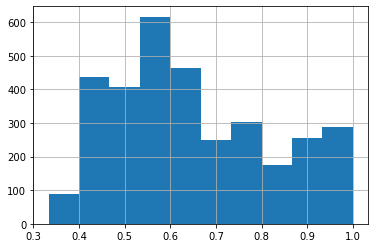

In [81]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [82]:
chart_tracks_df['predicted_genre'].value_counts()

rock        1319
rnb         1037
acoustic     928
Name: predicted_genre, dtype: int64

### 5.  Artist Classifier

In [83]:
artist = 'Nyoy Volante'

In [84]:
artist_tracks_df = pd.read_csv('data/'+artist.lower()+'_album_tracks_data.csv')
artist_tracks_df = artist_tracks_df[artist_tracks_df['artist_name']==artist]

In [85]:
#Predict genres of the spotify charts
'''
feature_cols = ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
               ]
'''
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

artist_tracks_df['predicted_genre_id'] = artist_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
artist_tracks_df['predicted_genre'] = artist_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
artist_tracks_df['predicted_genre_prob'] = artist_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
artist_tracks_df['all_genre_prob'] = artist_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 39


In [86]:
#explore genre probabilities into separate columns
artist_predicted_genre_prob = pd.DataFrame(artist_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
artist_predicted_genre_prob['track_id'] = artist_tracks_df['track_id']
artist_tracks_df = pd.merge(artist_tracks_df,artist_predicted_genre_prob, how='left', on='track_id')
artist_tracks_df = artist_tracks_df.drop(columns='all_genre_prob')
artist_tracks_df = artist_tracks_df.sort_values('predicted_genre_prob', ascending=False)
artist_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,playlist_id,playlist_name,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_acoustic_prob,predicted_rnb_prob,predicted_rock_prob
44,3MYfcVRTLqo7t3ra4DqFRn,Ama Namin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,1maIgsJ7htTqCDrhe8aucE,113640,2008-08-09,10,0.000,0.118,...,0.000,0.000,3MYfcVRTLqo7t3ra4DqFRn,3MYfcVRTLqo7t3ra4DqFRn,0,acoustic,0.948718,0.948718,0.051282,0.000000
0,2pAFgfaNVioQGhC0jhtcsG,Ipagpatawad Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,239333,2012-01-01,29,0.622,0.522,...,0.375,139.938,2pAFgfaNVioQGhC0jhtcsG,2pAFgfaNVioQGhC0jhtcsG,0,acoustic,0.410256,0.410256,0.205128,0.384615
63,4wt6antGdiSjTZWoyLVibi,Sweetest Sugar,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,225120,2002-06-01,1,0.655,0.650,...,0.607,96.063,4wt6antGdiSjTZWoyLVibi,4wt6antGdiSjTZWoyLVibi,0,acoustic,0.410256,0.410256,0.205128,0.384615
73,6m9YKCOZpdkLzPqUwCM9ha,Chosen,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,6wh0T0S950yhOVVT6kJjm2,313541,2018-05-08,8,0.570,0.714,...,0.449,130.058,6m9YKCOZpdkLzPqUwCM9ha,6m9YKCOZpdkLzPqUwCM9ha,0,acoustic,0.410256,0.410256,0.205128,0.384615
72,79cNKZg5oo2FHmnj99K8rQ,Pieces of My Life,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2Gxsv9XrzRkrjexEWWaxaH,291830,2019-04-11,0,0.298,0.213,...,0.348,175.989,79cNKZg5oo2FHmnj99K8rQ,79cNKZg5oo2FHmnj99K8rQ,0,acoustic,0.410256,0.410256,0.205128,0.384615


Check out tracks with highest assigned probability

In [87]:
artist_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
44,Nyoy Volante,Ama Namin,acoustic,0.948718
0,Nyoy Volante,Ipagpatawad Mo,acoustic,0.410256
63,Nyoy Volante,Sweetest Sugar,acoustic,0.410256
73,Nyoy Volante,Chosen,acoustic,0.410256
72,Nyoy Volante,Pieces of My Life,acoustic,0.410256


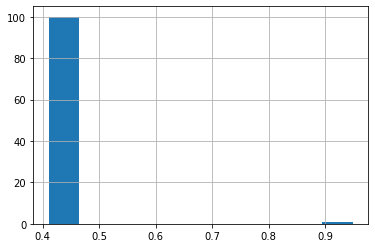

In [88]:
artist_tracks_df['predicted_genre_prob'].hist()

In [89]:
artist_tracks_df['predicted_genre'].value_counts()

acoustic    101
Name: predicted_genre, dtype: int64

In [90]:
genre_names = ['Acoustic']
playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)
#make duration ms to minutes
tracks_df['duration_mins']=tracks_df['duration']/60000
#tag genre with keyword

# scale loudness and tempo
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
tracks_df['popularity'] =  scaler.fit_transform(tracks_df[['popularity']])

tracks_df.head()

Acoustic


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins
0,1HrVc40jQbDRWIB9KreDti,Dreams - Piano Version,3j4FHbC5zwmYGJ7r0ZgaMt,Lissie,1oBjEkE3FjyD74adBZsUTI,274992,2019-03-01,0.494382,0.562,0.187,...,0.0313,0.921,0.0000,0.0813,0.199,0.408624,37i9dQZF1DWXmlLSKkfdAk,acoustic,Acoustic Covers,4.583200
1,66aH9gXNBfTJUikVIZfzcA,Days Like This,5KNNVgR6LBIABRIomyCwKJ,Dermot Kennedy,55yX6dAMACVgUGxG2RCnIq,149803,2020-11-06,0.494382,0.642,0.214,...,0.1980,0.909,0.0000,0.1220,0.380,0.170497,37i9dQZF1DWXmlLSKkfdAk,acoustic,Acoustic Covers,2.496717
2,79ms40oOzof3LMyrrXDXtJ,Fast Car (feat. Tall Heights),5Q2ZtOZ0vOdtcjGDOq6ZQc,Ryan Montbleau,0aqbYdpaGt1QhCJDcruuMV,272966,2014-09-30,0.696629,0.577,0.170,...,0.0462,0.865,0.0000,0.1330,0.360,0.771411,37i9dQZF1DWXmlLSKkfdAk,acoustic,Acoustic Covers,4.549433
3,6itWAD2WxmAVQgWuk85yXx,Stay With Me - Live From Spotify Berlin,4tvKz56Tr39bkhcQUTO0Xr,Angus & Julia Stone,5ota1DtixKfUcrsiazzgcK,174373,2015-01-13,0.573034,0.614,0.106,...,0.0413,0.838,0.0509,0.7080,0.169,0.141306,37i9dQZF1DWXmlLSKkfdAk,acoustic,Acoustic Covers,2.906217
4,65YDMuJmyF8cxTrk4Xogy0,Every Breath You Take (feat. Liza Anne),52MFUXZatn0KsT2bdPQI2a,Aaron Krause,0AQ6evdrI5Nkmp5lDYYCCh,223893,2013-11-22,0.719101,0.325,0.201,...,0.0282,0.758,0.0000,0.0977,0.172,0.179631,37i9dQZF1DWXmlLSKkfdAk,acoustic,Acoustic Covers,3.731550


In [91]:
artist_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,playlist_id,playlist_name,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_acoustic_prob,predicted_rnb_prob,predicted_rock_prob
44,3MYfcVRTLqo7t3ra4DqFRn,Ama Namin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,1maIgsJ7htTqCDrhe8aucE,113640,2008-08-09,10,0.000,0.118,...,0.000,0.000,3MYfcVRTLqo7t3ra4DqFRn,3MYfcVRTLqo7t3ra4DqFRn,0,acoustic,0.948718,0.948718,0.051282,0.000000
0,2pAFgfaNVioQGhC0jhtcsG,Ipagpatawad Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,239333,2012-01-01,29,0.622,0.522,...,0.375,139.938,2pAFgfaNVioQGhC0jhtcsG,2pAFgfaNVioQGhC0jhtcsG,0,acoustic,0.410256,0.410256,0.205128,0.384615
63,4wt6antGdiSjTZWoyLVibi,Sweetest Sugar,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,225120,2002-06-01,1,0.655,0.650,...,0.607,96.063,4wt6antGdiSjTZWoyLVibi,4wt6antGdiSjTZWoyLVibi,0,acoustic,0.410256,0.410256,0.205128,0.384615
73,6m9YKCOZpdkLzPqUwCM9ha,Chosen,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,6wh0T0S950yhOVVT6kJjm2,313541,2018-05-08,8,0.570,0.714,...,0.449,130.058,6m9YKCOZpdkLzPqUwCM9ha,6m9YKCOZpdkLzPqUwCM9ha,0,acoustic,0.410256,0.410256,0.205128,0.384615
72,79cNKZg5oo2FHmnj99K8rQ,Pieces of My Life,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2Gxsv9XrzRkrjexEWWaxaH,291830,2019-04-11,0,0.298,0.213,...,0.348,175.989,79cNKZg5oo2FHmnj99K8rQ,79cNKZg5oo2FHmnj99K8rQ,0,acoustic,0.410256,0.410256,0.205128,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2WTu0omgDUeO5pBismnvlb,Dude,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,270666,2010-01-01,2,0.439,0.579,...,0.717,204.353,2WTu0omgDUeO5pBismnvlb,2WTu0omgDUeO5pBismnvlb,0,acoustic,0.410256,0.410256,0.205128,0.384615
29,0Vb4bx3WLXa047jchCForj,Forever,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,277426,2010-01-01,3,0.548,0.349,...,0.318,140.070,0Vb4bx3WLXa047jchCForj,0Vb4bx3WLXa047jchCForj,0,acoustic,0.410256,0.410256,0.205128,0.384615
28,17Af5eAqoLqnDBdTe98kP7,So Hard to Let Go,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,279080,2010-01-01,8,0.498,0.291,...,0.239,141.862,17Af5eAqoLqnDBdTe98kP7,17Af5eAqoLqnDBdTe98kP7,0,acoustic,0.410256,0.410256,0.205128,0.384615
27,4M6YrTyOE1PWLIx1bqVcaA,In You,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,292800,2010-01-01,7,0.586,0.698,...,0.515,87.603,4M6YrTyOE1PWLIx1bqVcaA,4M6YrTyOE1PWLIx1bqVcaA,0,acoustic,0.410256,0.410256,0.205128,0.384615


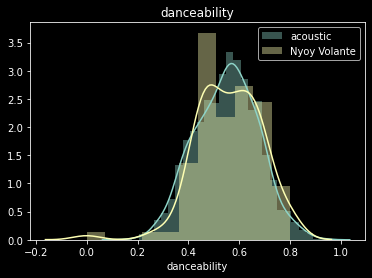

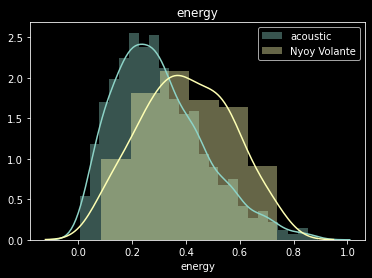

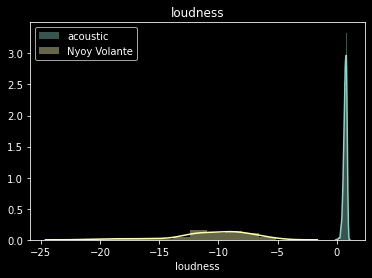

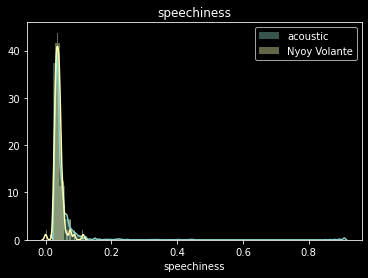

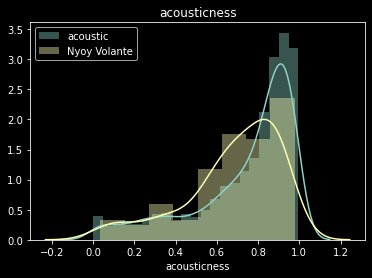

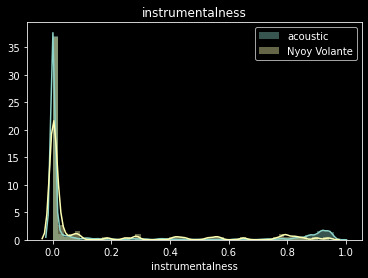

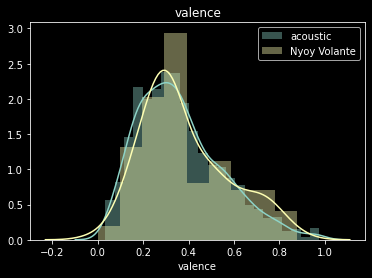

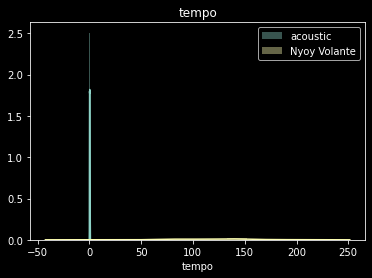

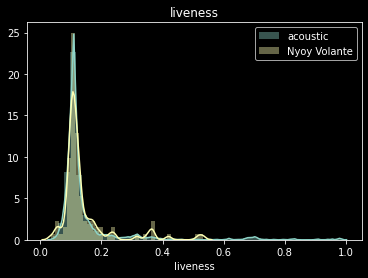

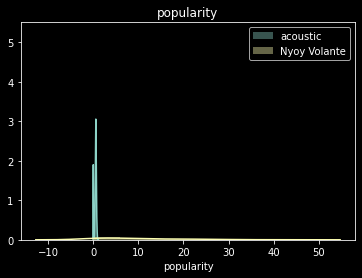

In [92]:
features = ['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'valence', 'tempo', 'liveness', 'popularity']
for feature in features:
    for genre in tracks_df['genre'].unique():
        data = tracks_df[tracks_df['genre']==genre]
        nyoy = artist_tracks_df
        plt.style.use("dark_background")
        sns.distplot(data[feature], label = genre)
        sns.distplot(nyoy[feature], label = 'Nyoy Volante')
    plt.legend()
    plt.title(feature)
    plt.show()